# Spatial variation of Airbnb characteristics in London: implications and recommendations for policymakers

## CASA0013: Foundations of Spatial Data Science

### Student Id: 21188261

#### You can find data and this notebook here: https://github.com/xiaohansu59/Airbnb.git

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import altair as alt
import libpysal as lps
import esda 
import numpy as np

In [2]:
# read in the Airbnb listing data, and convert the 'last_review' column to a datetime format

df = pd.read_csv('https://raw.githubusercontent.com/xiaohansu59/Airbnb/main/data/listings.csv')
df['last_review'] = pd.to_datetime(df['last_review'])

In [3]:
# group by room_type 

room_type_group_count = df.groupby("room_type").id.count().sort_values(ascending=False)
room_type_group_count = room_type_group_count.reset_index()
room_type_group_count.rename(columns={"id":"count"}, inplace=True)
room_type_group_count["percentage"]=round(room_type_group_count["count"] / room_type_group_count["count"].sum()*100,1)
room_type_group_count

room_type  count  percentage
0  Entire home/apt  41224        59.4
1     Private room  27479        39.6
2      Shared room    404         0.6
3       Hotel room    244         0.4

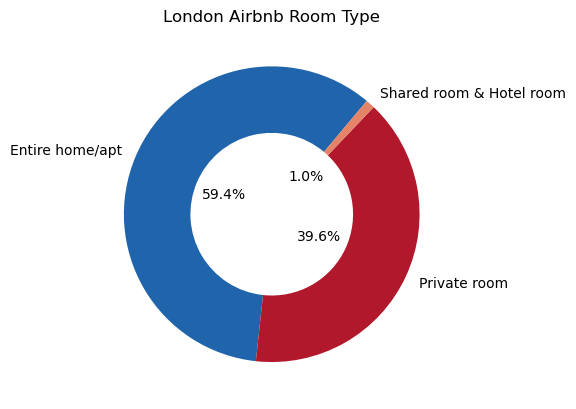

In [4]:
# draw a pie chart for room_type

import matplotlib
import matplotlib.pyplot as plt
cmap = matplotlib.cm.get_cmap('RdBu')

private_color = cmap(0.1)
entire_color = cmap(0.9)
shared_color = cmap(0.25)

fig1, ax1 = plt.subplots()
colors = [entire_color, private_color, shared_color]
data = [room_type_group_count.percentage[0], room_type_group_count.percentage[1],
        room_type_group_count.percentage[2] + room_type_group_count.percentage[3]]
labels = ['Entire home/apt', 'Private room', 'Shared room & Hotel room']
ax1.set_title('London Airbnb Room Type')

wedge, texts, autopct = ax1.pie(data, labels=labels, colors=colors,
                                startangle=50, wedgeprops={'width':0.45},
                                autopct='%1.1f%%', pctdistance=0.35)

In [5]:
# group by borough for count

borough_group_count = df.groupby("neighbourhood").id.count().sort_values(ascending=False)
borough_group_count = borough_group_count.reset_index()
borough_group_count.rename(columns={"id":"count"}, inplace=True)
borough_group_count.head(10)

neighbourhood  count
0             Westminster   7763
1           Tower Hamlets   5595
2                 Hackney   5168
3                  Camden   4707
4  Kensington and Chelsea   4612
5               Southwark   3968
6               Islington   3790
7                 Lambeth   3719
8              Wandsworth   3473
9  Hammersmith and Fulham   2996

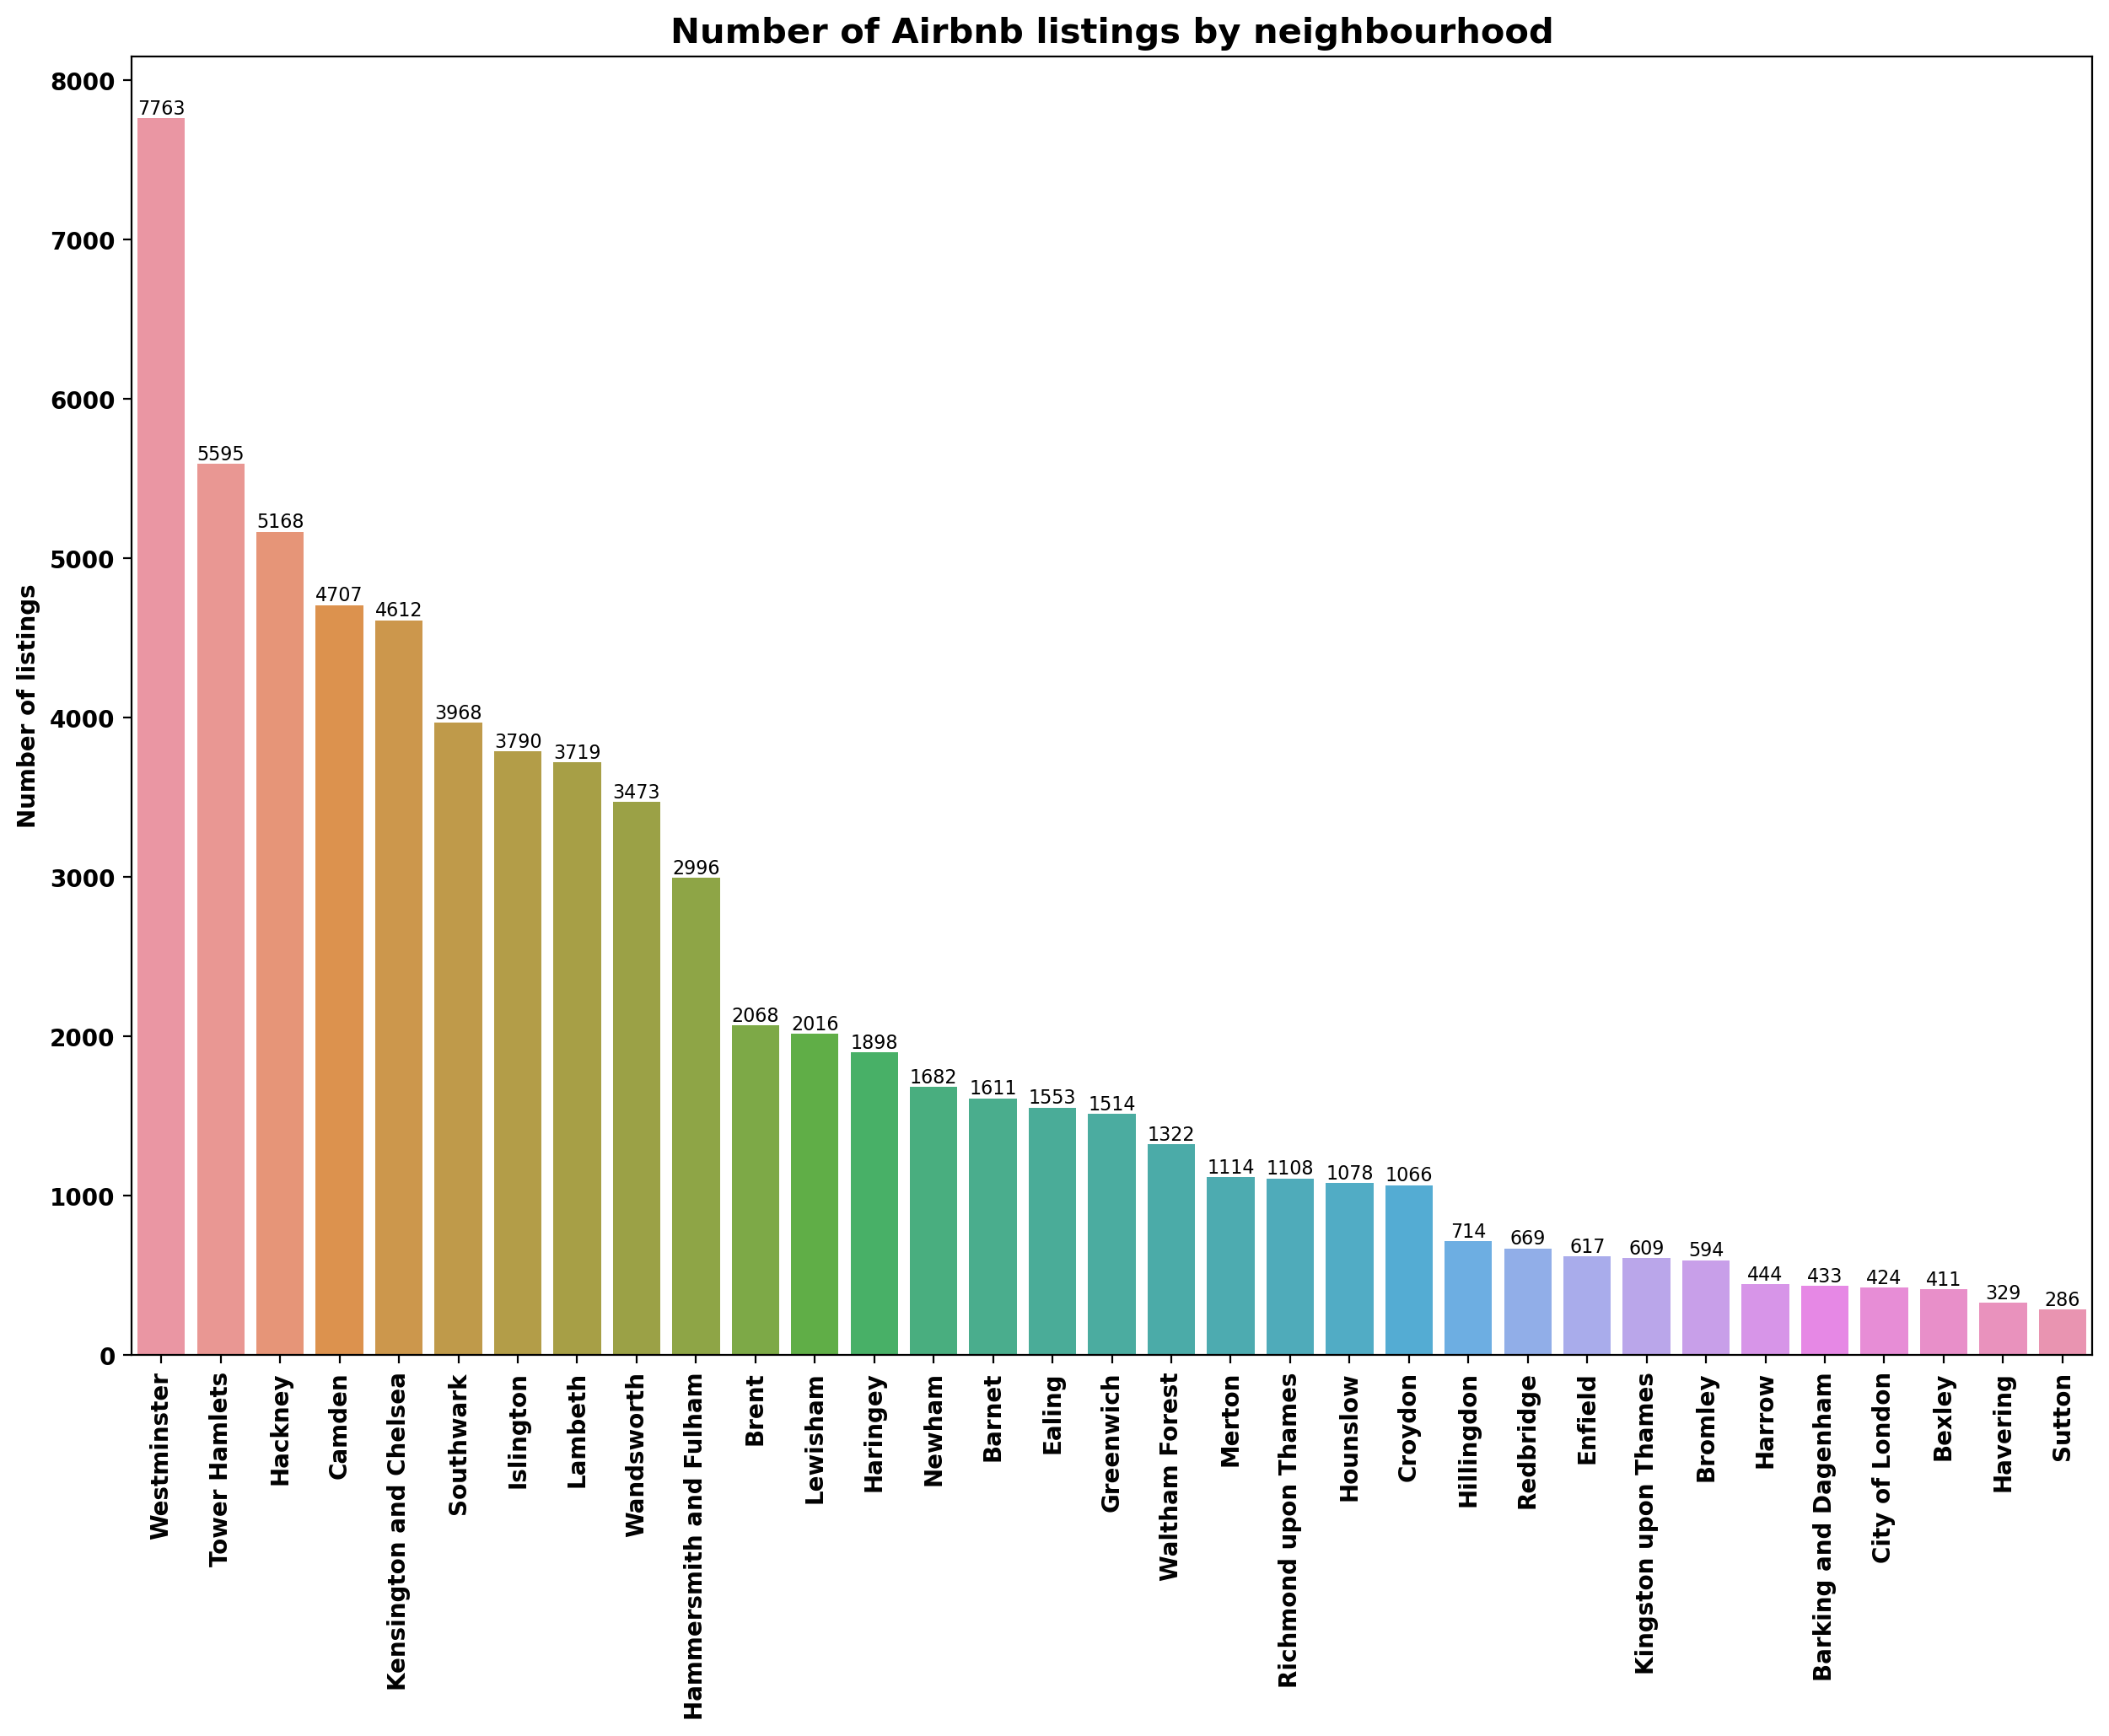

In [6]:
# barplot of listing count by borough 

plt.figure(figsize=(15,10),dpi=200)
plt.style.use('default')
ax = sns.barplot(x="neighbourhood", y="count", data=borough_group_count)
plt.title("Number of Airbnb listings by neighbourhood", weight="bold", fontsize=15) 
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Number of listings",weight= "bold",c="k")
plt.yticks(weight="bold")
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color='black', size=8)

plt.show()

In [7]:
# group by borough for price

borough_group_price = df.groupby("neighbourhood").price.mean().sort_values(ascending=False)
borough_group_price = borough_group_price.reset_index()
borough_group_price.head()

neighbourhood       price
0  Kensington and Chelsea  302.882047
1             Westminster  296.950148
2          City of London  269.063679
3  Hammersmith and Fulham  211.041389
4                   Brent  206.438104

In [8]:
avg_price = round(df.price.mean(),2)
print(f"The average Airbnb price in London is {avg_price}")

The average Airbnb price in London is 177.21


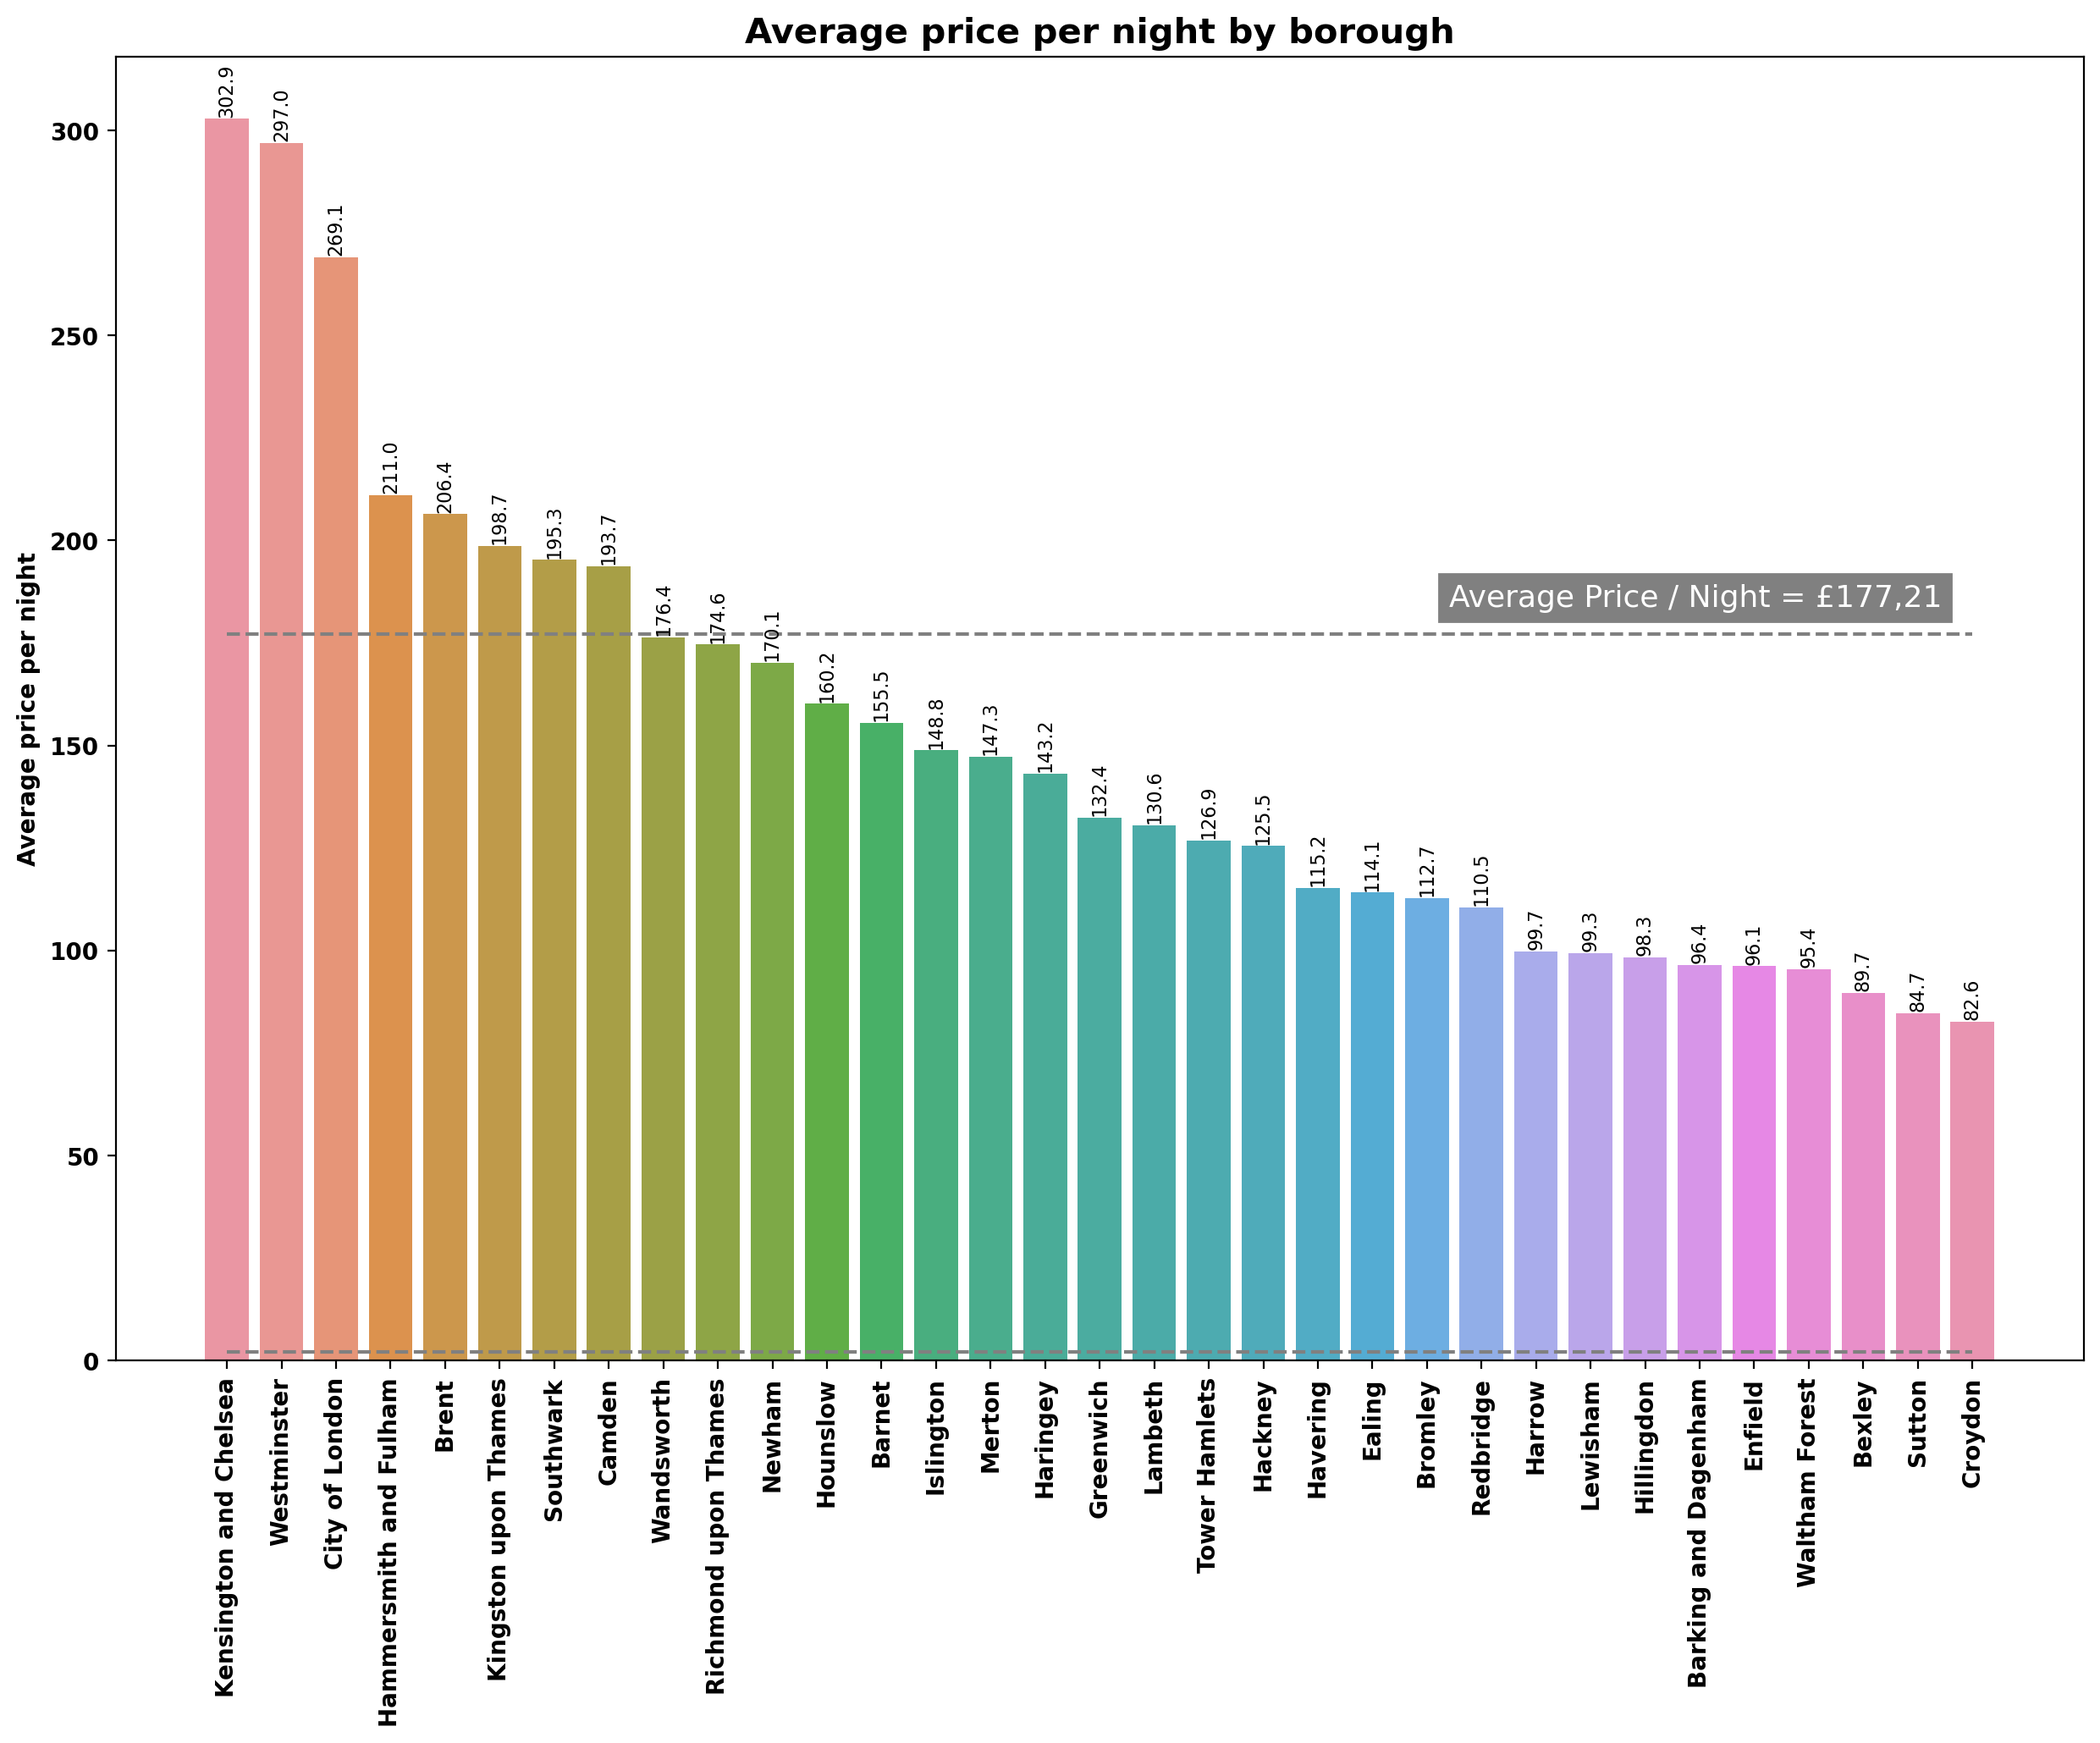

In [9]:
# barplot of average price by borough

plt.figure(figsize=(15,10),dpi=200)
plt.style.use('default')
ax = sns.barplot(x="neighbourhood", y="price", data=borough_group_price)
plt.title("Average price per night by borough", weight="bold", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=90, weight="bold")
plt.ylabel("Average price per night",weight="bold",c="k")
plt.yticks(weight="bold")
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+0.5),
                    ha='center', va='bottom',
                    color='black', size=8, rotation=90)

x_coordinates = [0, 32]
y_mean = [(df.price.mean(),2), (df.price.mean(),2)]

plt.plot(x_coordinates, y_mean, linestyle = '--', c="gray")
plt.text(22.4,184,'Average Price / Night = £177,21',fontsize = 13,backgroundcolor = 'gray',color = 'white')

plt.show()

In [10]:
# calculate the median price for each room type

median_prices = df.groupby('room_type')['price'].median()
median_prices

room_type
Entire home/apt    149.0
Hotel room         202.0
Private room        50.0
Shared room         39.0
Name: price, dtype: float64

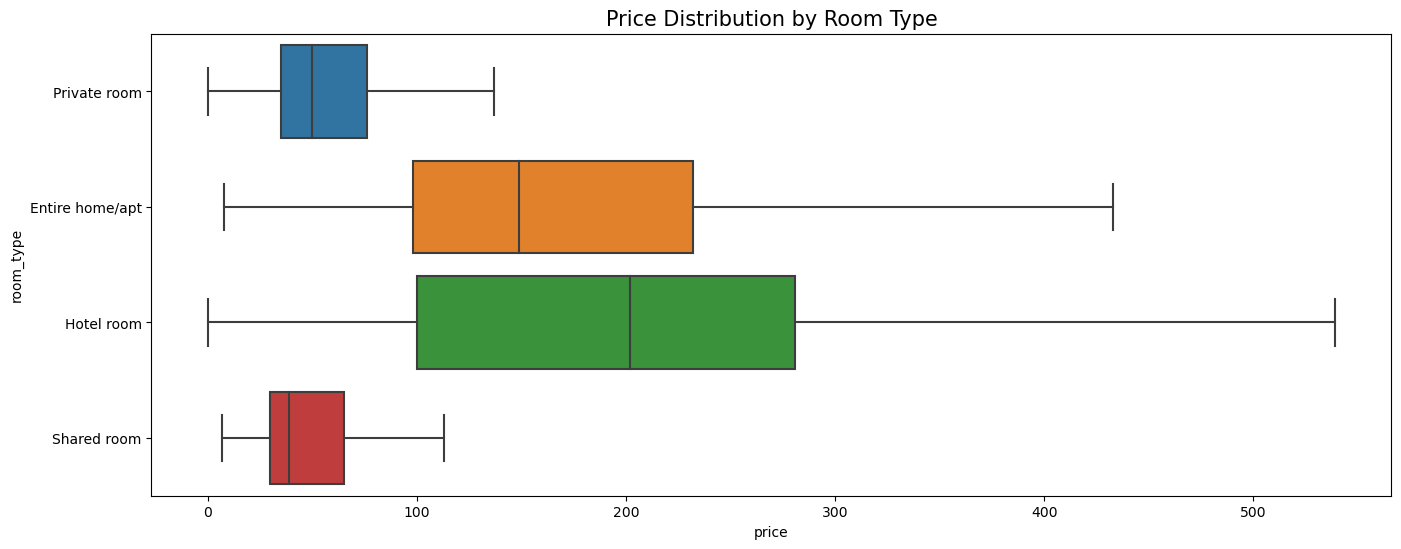

In [11]:
# plot the price distribution by room type

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="price", y="room_type", data=df, showfliers=False)
ax.set_title("Price Distribution by Room Type", fontsize=15);

In [12]:
# read in the neighbourhood geojson file

gdf = gpd.read_file('https://raw.githubusercontent.com/xiaohansu59/Airbnb/main/data/neighbourhoods.geojson')

In [13]:
# select useful columns

cols = ['neighbourhood', 'geometry']
gdf = gdf.loc[:, cols]

In [14]:
# merge data

df['mean_price'] = df.groupby('neighbourhood')['price'].transform('mean')
merged_df = gdf.merge(df, how='inner', on='neighbourhood')
merged_df = merged_df[['geometry','neighbourhood','mean_price']].drop_duplicates()
number = df['neighbourhood'].value_counts()
nbh_cnt = pd.DataFrame({'neighbourhood':number.index,'number':number.values})
merged_df = pd.merge(merged_df,nbh_cnt,on='neighbourhood',how='inner')

In [15]:
# print the result by price

merged_df.sort_values(by='mean_price', ascending=False)

geometry           neighbourhood  \
23  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...  Kensington and Chelsea   
25  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...             Westminster   
24  MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...          City of London   
22  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...  Hammersmith and Fulham   
8   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...                   Brent   
0   MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...    Kingston upon Thames   
15  MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...               Southwark   
26  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...                  Camden   
21  MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...              Wandsworth   
19  MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...    Richmond upon Thames   
31  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...                  Newham   
3   MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...                Hounslow   
9   MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...                  Barnet   
28  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...               Islington   
20  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...                  Merton   
30  MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...                Haringey   
17  MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...               Greenwich   
14  MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...                 Lambeth   
27  MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...           Tower Hamlets   
29  MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...                 Hackney   
5   MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...                Havering   
4   MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...                  Ealing   
2   MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...                 Bromley   
12  MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...               Redbridge   
7   MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...                  Harrow   
16  MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...                Lewisham   
6   MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...              Hillingdon   
32  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...    Barking and Dagenham   
10  MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...                 Enfield   
11  MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...          Waltham Forest   
18  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...                  Bexley   
13  MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...                  Sutton   
1   MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...                 Croydon   

    mean_price  number  
23  302.882047    4612  
25  296.950148    7763  
24  269.063679     424  
22  211.041389    2996  
8   206.438104    2068  
0   198.673235     609  
15  195.298387    3968  
26  193.725303    4707  
21  176.366254    3473  
19  174.631769    1108  
31  170.124257    1682  
3   160.189239    1078  
9   155.468653    1611  
28  148.832718    3790  
20  147.291741    1114  
30  143.168072    1898  
17  132.355350    1514  
14  130.569508    3719  
27  126.876139    5595  
29  125.466331    5168  
5   115.191489     329  
4   114.104314    1553  
2   112.742424     594  
12  110.484305     669  
7    99.702703     444  
16   99.341270    2016  
6    98.271709     714  
32   96.411085     433  
10   96.119935     617  
11   95.408472    1322  
18   89.686131     411  
13   84.674825     286  
1    82.561914    1066

In [16]:
# print the result by listing number

merged_df.sort_values(by='number', ascending=False)

geometry           neighbourhood  \
25  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...             Westminster   
27  MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...           Tower Hamlets   
29  MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...                 Hackney   
26  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...                  Camden   
23  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...  Kensington and Chelsea   
15  MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...               Southwark   
28  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...               Islington   
14  MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...                 Lambeth   
21  MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...              Wandsworth   
22  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...  Hammersmith and Fulham   
8   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...                   Brent   
16  MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...                Lewisham   
30  MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...                Haringey   
31  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...                  Newham   
9   MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...                  Barnet   
4   MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...                  Ealing   
17  MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...               Greenwich   
11  MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...          Waltham Forest   
20  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...                  Merton   
19  MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...    Richmond upon Thames   
3   MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...                Hounslow   
1   MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...                 Croydon   
6   MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...              Hillingdon   
12  MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...               Redbridge   
10  MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...                 Enfield   
0   MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...    Kingston upon Thames   
2   MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...                 Bromley   
7   MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...                  Harrow   
32  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...    Barking and Dagenham   
24  MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...          City of London   
18  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...                  Bexley   
5   MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...                Havering   
13  MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...                  Sutton   

    mean_price  number  
25  296.950148    7763  
27  126.876139    5595  
29  125.466331    5168  
26  193.725303    4707  
23  302.882047    4612  
15  195.298387    3968  
28  148.832718    3790  
14  130.569508    3719  
21  176.366254    3473  
22  211.041389    2996  
8   206.438104    2068  
16   99.341270    2016  
30  143.168072    1898  
31  170.124257    1682  
9   155.468653    1611  
4   114.104314    1553  
17  132.355350    1514  
11   95.408472    1322  
20  147.291741    1114  
19  174.631769    1108  
3   160.189239    1078  
1    82.561914    1066  
6    98.271709     714  
12  110.484305     669  
10   96.119935     617  
0   198.673235     609  
2   112.742424     594  
7    99.702703     444  
32   96.411085     433  
24  269.063679     424  
18   89.686131     411  
5   115.191489     329  
13   84.674825     286

In [17]:
# this function generates an interactive map chart

def gen_map_chart(df, review_col, review_title):
    chart = alt.Chart(
        df,
        title=review_title
    ).mark_geoshape().encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=500, 
        height=500
    )
    
    return chart

In [18]:
# display the listing count distribution

cnt = gen_map_chart(merged_df, 'number', 'Number of Airbnb listings by borough')
cnt

alt.Chart(...)

In [19]:
# display the average price distribution

average_price = gen_map_chart(merged_df, 'mean_price', 'Average price of Airbnb listings by borough')
average_price

alt.Chart(...)

In [20]:
# calculate the global Moran's I 

wq = lps.weights.Queen.from_dataframe(merged_df)
wq.transform = 'r'
np.random.seed(12345)
y = merged_df['mean_price']
mi = esda.moran.Moran(y, wq)
print('The global Moran I of the average price of Airbnb rentals in London is {:.3f}'.format(mi.I))

The global Moran I of the average price of Airbnb rentals in London is 0.448


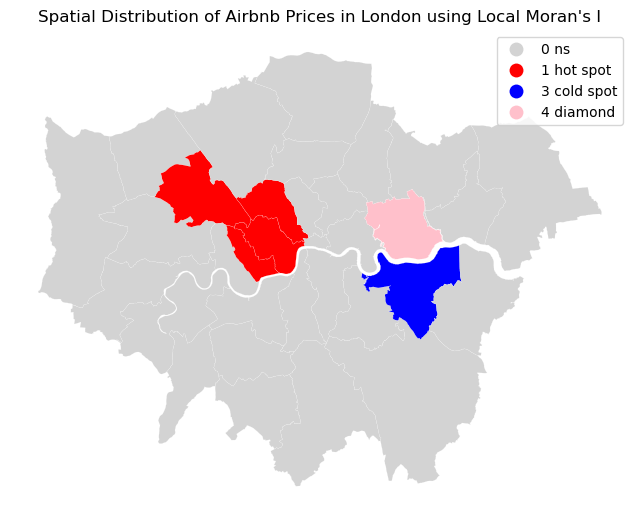

In [21]:
# display the spatial correlation of mean price using local Moran's I

li = esda.moran.Moran_Local(y, wq)
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

from matplotlib import colors
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(8, 8))
merged_df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Distribution of Airbnb Prices in London using Local Moran's I")
plt.show()

In [22]:
# read in the boroughs geopackage file

boros = gpd.read_file('https://github.com/xiaohansu59/Airbnb/blob/main/data/boroughs.gpkg?raw=true')

In [23]:
# select useful columns of the listing data

sub_cols=['latitude','longitude','room_type','last_review']
sub_df=df[sub_cols]

In [24]:
# create a geodataframe and reproject

sub_df = gpd.GeoDataFrame(sub_df, geometry=gpd.points_from_xy(sub_df.longitude, sub_df.latitude), crs= 'epsg:4326')
sub_df.to_crs('epsg:27700', inplace=True)

In [25]:
# select active listings (last_review >= 2021-09-10)

active_listings = sub_df.drop(sub_df[sub_df.last_review.isna()].index.values, axis=0)
active_listings = active_listings.loc[active_listings["last_review"] >= '2021-09-10']

In [26]:
# print the result

print(f"There are {active_listings.shape[0]} active listings and {sub_df.shape[0]} total listings.")
print(f"The active listings are {active_listings.shape[0] *100 / sub_df.shape[0]:,.2f}% of the total listings.")

There are 31336 active listings and 69351 total listings.
The active listings are 45.18% of the total listings.


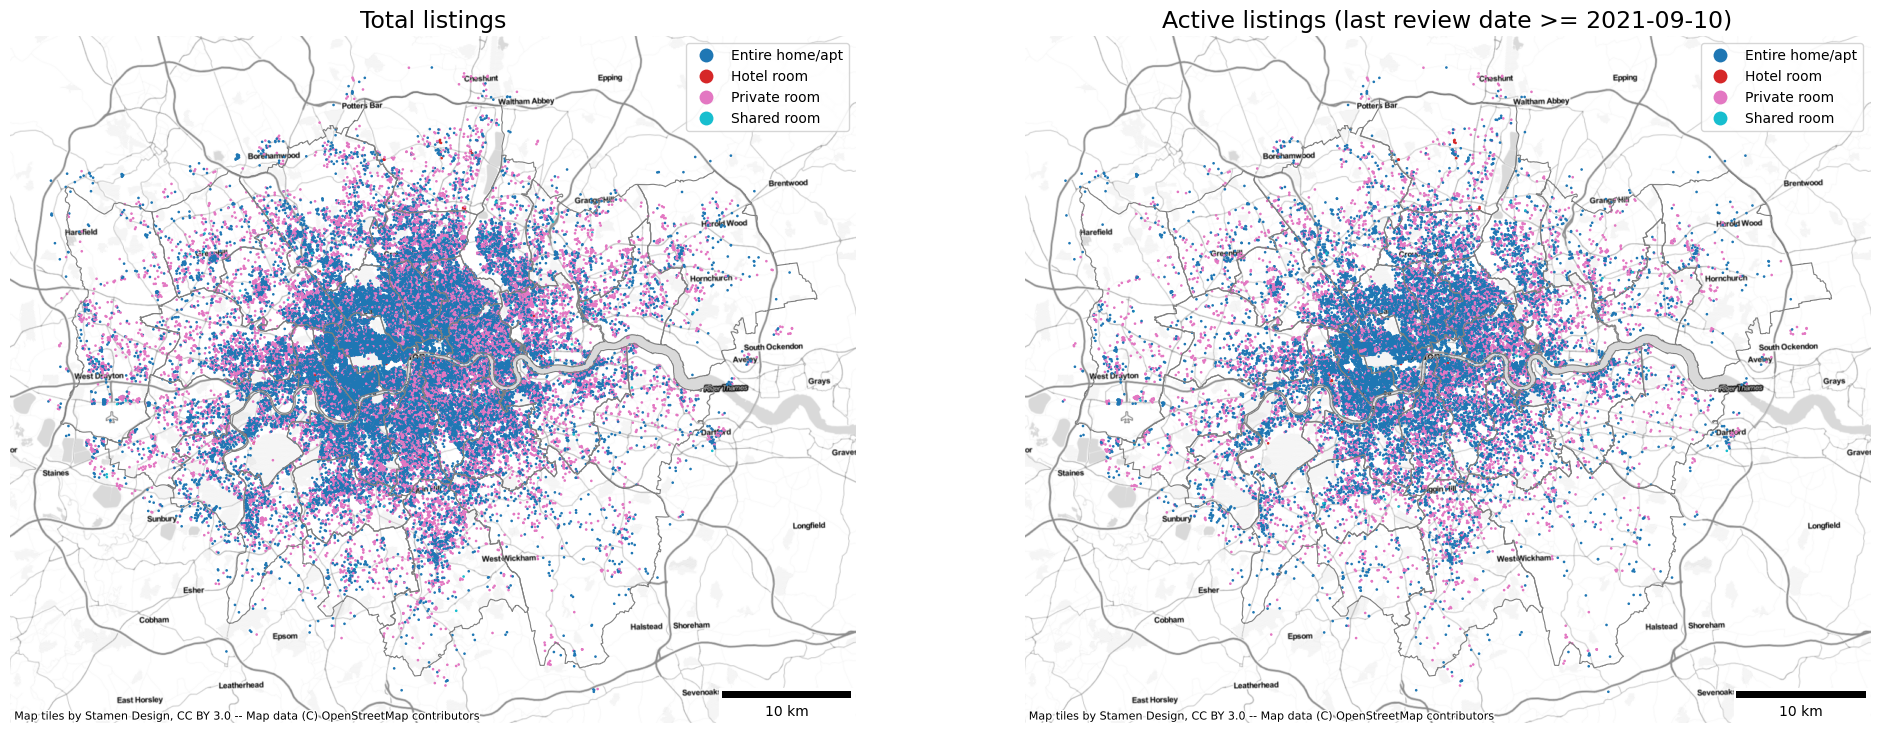

In [27]:
# plot the total and active listings

from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

fig, axes = plt.subplots(1,2, figsize = (24,16))

plt1 = "Total listings"
plt2 = "Active listings (last review date >= 2021-09-10)"

scale1 = ScaleBar(dx=1, location='lower right', label_loc='left', scale_loc='bottom')
scale2 = ScaleBar(dx=1, location='lower right', label_loc='left', scale_loc='bottom')

# plot the total listings
boros.boundary.plot(ax=axes[0], edgecolor = "grey", linewidth=0.8)
sub_df.plot(ax = axes[0], cmap="tab10", column="room_type", markersize = 0.8, legend=True)
ctx.add_basemap(ax=axes[0], crs=boros.crs, source = ctx.providers.Stamen.TonerLite)
axes[0].add_artist(scale1)

# plot the active listings
boros.boundary.plot(ax=axes[1], edgecolor = "grey", linewidth=0.8)
active_listings.plot(ax = axes[1], cmap="tab10", column="room_type", markersize = 0.8, legend=True)
ctx.add_basemap(ax=axes[1], crs=boros.crs, source = ctx.providers.Stamen.TonerLite)
axes[1].add_artist(scale2)

for ax in axes:
    ax.axis('off')
    
axes[0].set_title(plt1, size=17);
axes[1].set_title(plt2, size=17);

In [28]:
# read in the detailed listing data

listings_detail_df = pd.read_csv('http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/data/listings.csv.gz')

In [29]:
# select columns related to review_scores

review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
listing_detail_cols = ['id', 'neighbourhood_cleansed'] + review_cols

res_listings_detail_df = listings_detail_df[listings_detail_df['host_name'].notnull()]
# Only keep the rows where all the review scores are present
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df.filter(regex='review_scores').notnull().all(axis=1)]
res_listings_detail_df = res_listings_detail_df[listing_detail_cols].rename({'neighbourhood_cleansed': 'neighbourhood'}, axis=1)
res_listings_detail_df.head()

id           neighbourhood  review_scores_accuracy  \
0   13913               Islington                    4.82   
1   15400  Kensington and Chelsea                    4.84   
2  284532           Tower Hamlets                    4.53   
3  106332           Tower Hamlets                    4.91   
4   17402             Westminster                    4.82   

   review_scores_cleanliness  review_scores_checkin  \
0                       4.89                   4.86   
1                       4.88                   4.87   
2                       4.03                   4.72   
3                       4.71                   4.93   
4                       4.69                   4.69   

   review_scores_communication  review_scores_location  review_scores_value  
0                         4.93                    4.75                 4.82  
1                         4.82                    4.93                 4.73  
2                         4.86                    4.72                 4.31  
3                         4.93                    4.92                 4.83  
4                         4.69                    4.88                 4.59

In [30]:
# merge data and calcute the mean value of each review type

geo_listings_df = gdf.merge(res_listings_detail_df, how='inner', on='neighbourhood')
geo_listings_df['mean_review_scores_accuracy'] = geo_listings_df.groupby('neighbourhood')['review_scores_accuracy'].transform('mean')
geo_listings_df['mean_review_scores_cleanliness'] = geo_listings_df.groupby('neighbourhood')['review_scores_cleanliness'].transform('mean')
geo_listings_df['mean_review_scores_checkin'] = geo_listings_df.groupby('neighbourhood')['review_scores_checkin'].transform('mean')
geo_listings_df['mean_review_scores_communication'] = geo_listings_df.groupby('neighbourhood')['review_scores_communication'].transform('mean')
geo_listings_df['mean_review_scores_location'] = geo_listings_df.groupby('neighbourhood')['review_scores_location'].transform('mean')
geo_listings_df['mean_review_scores_value'] = geo_listings_df.groupby('neighbourhood')['review_scores_value'].transform('mean')
geo_listings_df['mean_review_scores_all'] = geo_listings_df.filter(like='mean_review_scores').mean(axis=1)

In [31]:
# plot the average review scores by neighbourhood

review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin',
               'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}
result_df = geo_listings_df[['geometry', 'neighbourhood', 'mean_review_scores_all'] + review_cols].drop_duplicates()

def gen_map_chart(df, review_col, review_title):
    
    chart = alt.Chart(
        df,
        title=review_title
    ).mark_geoshape().encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=280, 
        height=280
    )
    
    return chart

charts = []

for review_col, review_title in zip(review_cols, review_titles):
    charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*charts, columns=3), overall_map_chart, 
              title='Average review scores by neighbourhood', 
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top', labelFontSize=12)))

alt.VConcatChart(...)

In [32]:
# print the result in descending order of overall scores

result_df.sort_values(by='mean_review_scores_all', ascending=False)

geometry  \
18156  MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...   
0      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...   
44767  MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...   
19817  MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...   
9345   MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...   
3612   MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...   
41903  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...   
19005  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...   
1250   MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...   
2473   MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...   
7710   MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...   
9145   MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...   
4389   MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...   
15232  MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...   
48664  MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...   
22391  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...   
12208  MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...   
34102  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...   
4687   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...   
16741  MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...   
1686   MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...   
37760  MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...   
6175   MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...   
28031  MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...   
451    MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...   
7251   MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...   
24630  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...   
50042  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...   
3841   MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...   
28351  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...   
8687   MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...   
51214  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...   
17864  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...   

                neighbourhood  mean_review_scores_all  \
18156    Richmond upon Thames                4.836606   
0        Kingston upon Thames                4.808914   
44767                 Hackney                4.773667   
19817              Wandsworth                4.773478   
9345                  Lambeth                4.771610   
3612                 Havering                4.752889   
41903               Islington                4.751234   
19005                  Merton                4.748183   
1250                  Bromley                4.744836   
2473                   Ealing                4.737594   
7710           Waltham Forest                4.731308   
9145                   Sutton                4.730858   
4389                   Harrow                4.728210   
15232                Lewisham                4.723735   
48664                Haringey                4.712704   
22391  Hammersmith and Fulham                4.712268   
12208               Southwark                4.709652   
34102                  Camden                4.706220   
4687                    Brent                4.704500   
16741               Greenwich                4.703091   
1686                 Hounslow                4.702891   
37760           Tower Hamlets                4.691011   
6175                   Barnet                4.690564   
28031          City of London                4.689911   
451                   Croydon                4.684460   
7251                  Enfield                4.683809   
24630  Kensington and Chelsea                4.683050   
50042                  Newham                4.676022   
3841               Hillingdon                4.672123   
28351             Westminster                4.668729   
8687                Redbridge                4.661710   
51214    Barking and Dagenham                4.659600   
17864                  Bexley                4.652003   

       mean_review_scores_accuracy  mean_review_scores_cleanliness  

In [33]:
# print the result in descending order of location scores

result_df.sort_values(by='mean_review_scores_location', ascending=False)

geometry  \
18156  MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...   
28031  MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...   
24630  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...   
28351  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...   
34102  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...   
41903  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...   
0      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...   
44767  MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...   
19817  MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...   
9345   MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...   
22391  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...   
19005  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...   
4389   MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...   
3612   MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...   
9145   MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...   
12208  MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...   
1250   MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...   
37760  MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...   
2473   MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...   
1686   MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...   
3841   MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...   
6175   MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...   
7710   MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...   
16741  MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...   
48664  MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...   
4687   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...   
15232  MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...   
50042  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...   
7251   MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...   
451    MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...   
17864  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...   
8687   MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...   
51214  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...   

                neighbourhood  mean_review_scores_all  \
18156    Richmond upon Thames                4.836606   
28031          City of London                4.689911   
24630  Kensington and Chelsea                4.683050   
28351             Westminster                4.668729   
34102                  Camden                4.706220   
41903               Islington                4.751234   
0        Kingston upon Thames                4.808914   
44767                 Hackney                4.773667   
19817              Wandsworth                4.773478   
9345                  Lambeth                4.771610   
22391  Hammersmith and Fulham                4.712268   
19005                  Merton                4.748183   
4389                   Harrow                4.728210   
3612                 Havering                4.752889   
9145                   Sutton                4.730858   
12208               Southwark                4.709652   
1250                  Bromley                4.744836   
37760           Tower Hamlets                4.691011   
2473                   Ealing                4.737594   
1686                 Hounslow                4.702891   
3841               Hillingdon                4.672123   
6175                   Barnet                4.690564   
7710           Waltham Forest                4.731308   
16741               Greenwich                4.703091   
48664                Haringey                4.712704   
4687                    Brent                4.704500   
15232                Lewisham                4.723735   
50042                  Newham                4.676022   
7251                  Enfield                4.683809   
451                   Croydon                4.684460   
17864                  Bexley                4.652003   
8687                Redbridge                4.661710   
51214    Barking and Dagenham                4.659600   

       mean_review_scores_accuracy  mean_review_scores_cleanliness  